# Automatic Differentiation

One of the main reasons for using PyTorch in deep learning is its ability to automatically compute the gradient of a function. More specifically, PyTorch has a built-in differentiation engine, called `torch.autograd`, which tracks the operations performed on tensors. The history of computation is recorded in a data structure called a *computational graph*, which is then used to compute derivatives using the chain rule. In this notebook, we will explore the basics of automatic differentiation in PyTorch.


In [1]:
import torch

## Computational graph

In order to get familiar with the concept of a computation graph, we will create one for the following function.

$$f(x) = \frac{1}{N}\sum_{i=1}^N \left[(x_i + 2)^2 + 3\right]$$

The vector $x$ is the input of the function, so we will compute the gradient of $f(x)$ with respect to $x$. The gradient will be a tensor of the same shape as $x$.

```{note}
The gradient can only be computed for functions with a scalar output.
```

### Tensor with gradient

The first thing we have to do is to create the tensor that represents the vector $x$. We will set `requires_grad=True` to track the operations on this tensor. This will allow us to compute the gradient of $f(x)$ with respect to $x$. Note that by default, tensors are created without tracking operations on them.

In [2]:
x = torch.tensor([0., 1, 2], requires_grad=True)

Now let’s build the computation graph step by step. You can combine multiple operations in a single line, but we will separate them here  to better understand how each operation is added to the computation graph.

In [3]:
a = x + 2
b = a ** 2
c = b + 3
y = c.mean()  # f(x) evaluated at the values stored in x

print(y)

tensor(12.6667, grad_fn=<MeanBackward0>)


The statements above create a computation graph that looks similar to the figure below. The nodes represent the intermediate tensors, and the edges represent the operations that transform those tensors. The arrows point from the outputs to the inputs of each operation, because this is the direction in which the gradient will be computed.

![comp_graph](pics/computational_graph.png)

### Backpropagation

We can perform backpropagation on the computation graph by calling the function `backward()` on the last output. This calculates the gradients for each tensor that has the property `requires_grad=True`.

In [4]:
y.backward()

The gradients are stored in the `.grad` attribute of each tensor that has the property `requires_grad=True`. In this case, the attribute `x.grad` will now contain the gradient of $f(x)$ with respect to $x$, evaluated at the value of the tensor `x` that we used to build the computation graph.

In [5]:
x.grad

tensor([1.3333, 2.0000, 2.6667])

Note that if we recompute the tensor `y` and call `y.backward()` a second time, the gradient in `x.grad` will change. This happens because PyTorch accumulates the gradients in the `.grad` attribute, that is, it sums the new gradient with the old one.

In [6]:
a = x + 2
b = a ** 2
c = b + 3
y = c.mean()

y.backward()

x.grad

tensor([2.6667, 4.0000, 5.3333])

If we need to compute the gradient in a loop (e.g., to implement gradient descent), we have to zero out the gradient in each iteration before recomputing the output scalar tensor on which `backward()` is called. 

### Disabling gradient tracking

By default, all tensors with `requires_grad=True` are tracking their computational history and support gradient computation. However, there are some cases when we do not need to do that, for example, when we have trained a neural network and just want to apply it to some input data. 

We can stop tracking computations by surrounding our computation code with `torch.no_grad()` block.

In [7]:
x = torch.randn(5, requires_grad=True)

# Gradient is tracked
a = x * 2

# Tracking is stopped in the block
with torch.no_grad():
    z = x * 2

print("Does 'x' have a gradient?", x.requires_grad)
print("Does 'a' have a gradient?", a.requires_grad)
print("Does 'z' have a gradient?", z.requires_grad)

Does 'x' have a gradient? True
Does 'a' have a gradient? True
Does 'z' have a gradient? False


Another way to achieve the same result is to use the `detach()` method on the tensor.

In [8]:
a = x * 2
z = a.detach()

print("Does 'a' have a gradient?", a.requires_grad)
print("Does 'z' have a gradient?", z.requires_grad)

Does 'a' have a gradient? True
Does 'z' have a gradient? False


## Optimization

After understanding the fundamentals of autograd in PyTorchs, the next logical step is to apply this knowledge to practical optimization problems. One common task in machine learning and numerical analysis is finding the minimum of a function, a process that can be achieved using an optimization algorithm called *gradient descent*. PyTorch provides a variety of optimization algorithms that make this process efficient and straightforward. These algorithms are implemented in the `torch.optim` module.

### Loss function

In order to apply gradient descent, we need to define a function that we want to minimize. This function should take a PyTorch tensor as input and return a scalar output. For example, let's consider the following function of one variable.

$$
f(x) = x^4 + x^2 + 10x
$$

We can define this function in PyTorch as follows.

In [9]:
def function(x):
    return x ** 4 + x ** 2 + 10 * x

The goal is to find the value of $x$ that minimizes this expression.

### Initialization

The optimization process requires an initial guess. Hence, we need to create a tensor representing the initial value of $x$ and ensure it requires a gradient.

In [10]:
x = torch.tensor(0.0, requires_grad=True)

### Choosing an optimizer

PyTorch provides several optimization algorithms as part of the `torch.optim` module. We can choose one of them and pass the parameters to optimize and the learning rate. For example, we can use the stochastic gradient descent (SGD) algorithm with a learning rate of 0.05.

In [11]:
optimizer = torch.optim.SGD([x], lr=0.05)

All optimizers implement a `step()` method that updates the provided tensors based on the computed gradients, and a `zero_grad()` method that resets those gradients to zero.

### Running the optimization loop

The next step is to perform the optimization loop. Within each iteration, the following steps are performed.
 
 - Compute the value of the function by calling it with the current `x` value.

 - Perform backpropagation by invoking the `backward()` method on the computed function value. This populates the gradient in `x.grad`.

 - Update `x` by calling `optimizer.step()`, which applies a single step of the optimization algorithm.

 - Set the gradients to zero using `optimizer.zero_grad()`.

The loop can be run for a fixed number of steps or until the change in the function value is sufficiently small.

In [12]:
for i in range(10):
    loss = function(x)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"Iteration {i+1:2d}: x = {x.item():.5f}, f(x) = {loss.item():.5f}")

Iteration  1: x = -0.50000, f(x) = 0.00000
Iteration  2: x = -0.92500, f(x) = -4.68750
Iteration  3: x = -1.17421, f(x) = -7.66228
Iteration  4: x = -1.23300, f(x) = -8.46233
Iteration  5: x = -1.23480, f(x) = -8.49843
Iteration  6: x = -1.23477, f(x) = -8.49846
Iteration  7: x = -1.23477, f(x) = -8.49846
Iteration  8: x = -1.23477, f(x) = -8.49846
Iteration  9: x = -1.23477, f(x) = -8.49846
Iteration 10: x = -1.23477, f(x) = -8.49846


### Visualizing the result

Finally, we can visualize the function and the minimum value found by the optimization algorithm.

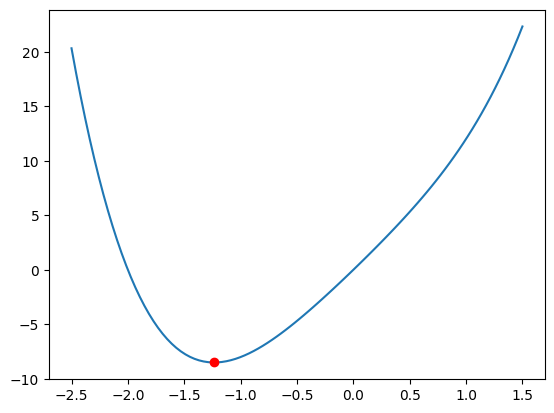

In [18]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(-2.5, 1.5, 100)
f = function(torch.tensor(t)).numpy()
plt.plot(t, f)
plt.plot(x.item(), function(x).item(), 'ro')
plt.show()

## Conclusion

In this notebook, we have explored the basics of automatic differentiation in PyTorch. We have seen how to create a computation graph, compute gradients, and perform optimization using the built-in optimization algorithms. This knowledge is essential for understanding how PyTorch works.